This notebook shows how to use TabPFN for tabular prediction with a scikit learn wrapper.

classifier = TabPFNClassifier(device='cpu')
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict(test_xs)

The fit function does not perform any computations, but only saves the training data. Computations are only done at inference time, when calling predict.
Note that the presaved models were trained for up to 100 features, 10 classes and 1000 samples. While the model does not have a hard bound on the number of samples, the features and classes are restricted and larger sizes lead to an error.

### Setup

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import time
import torch
import numpy as np
import os

from scripts.model_builder import get_default_spec, save_model, load_model_only_inference
from scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, TabPFNClassifier
from scripts.differentiable_pfn_evaluation import eval_model, eval_model_range

from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

from scripts import tabular_metrics
import random

In [3]:
base_path = '.'

### Load datasets

In [4]:
max_samples = 10000
bptt = 10000

cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = max_samples, num_feats=100, return_capped=True)
cc_valid_datasets_multiclass, cc_valid_datasets_multiclass_df = load_openml_list(open_cc_valid_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = max_samples, num_feats=100, return_capped=True)

# Loading longer OpenML Datasets for generalization experiments (optional)
# test_datasets_multiclass, test_datasets_multiclass_df = load_openml_list(test_dids_classification, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)

random.seed(0)
random.shuffle(cc_valid_datasets_multiclass)

Number of datasets: 30
Loading balance-scale 11 ..
Loading mfeat-fourier 14 ..
Loading breast-w 15 ..
Loading mfeat-karhunen 16 ..
Loading mfeat-morphological 18 ..
Loading mfeat-zernike 22 ..
Loading cmc 23 ..
Loading credit-approval 29 ..
Loading credit-g 31 ..
Loading diabetes 37 ..
Loading tic-tac-toe 50 ..
Loading vehicle 54 ..
Loading eucalyptus 188 ..
Loading analcatdata_authorship 458 ..
Loading analcatdata_dmft 469 ..
Loading pc4 1049 ..
Loading pc3 1050 ..
Loading kc2 1063 ..
Loading pc1 1068 ..
Loading banknote-authentication 1462 ..
Loading blood-transfusion-service-center 1464 ..
Loading ilpd 1480 ..
Loading qsar-biodeg 1494 ..
Loading wdbc 1510 ..
Loading cylinder-bands 6332 ..
Loading dresses-sales 23381 ..
Loading MiceProtein 40966 ..
Loading car 40975 ..
Loading steel-plates-fault 40982 ..
Loading climate-model-simulation-crashes 40994 ..
Number of datasets: 150
Loading breast-cancer 13 ..
Loading colic 25 ..
Loading dermatology 35 ..
Loading sonar 40 ..
Loading glass 

In [6]:
def get_datasets(selector, task_type, suite='cc'):
    if task_type == 'binary':
        ds = valid_datasets_binary if selector == 'valid' else test_datasets_binary
    else:
        if suite == 'openml':
            ds = valid_datasets_multiclass if selector == 'valid' else test_datasets_multiclass
        elif suite == 'cc':
            ds = cc_valid_datasets_multiclass if selector == 'valid' else cc_test_datasets_multiclass
        else:
            raise Exception("Unknown suite")
    return ds

In [7]:
model_string, longer, task_type = '', 1, 'multiclass'
eval_positions = [1000]
bptt = 2000
    
test_datasets, valid_datasets = get_datasets('test', task_type, suite='cc'), get_datasets('valid', task_type, suite='cc')

### Run on a single dataset

In [8]:
[(i, test_datasets[i][0]) for i in range(len(test_datasets))]

[(0, 'balance-scale'),
 (1, 'mfeat-fourier'),
 (2, 'breast-w'),
 (3, 'mfeat-karhunen'),
 (4, 'mfeat-morphological'),
 (5, 'mfeat-zernike'),
 (6, 'cmc'),
 (7, 'credit-approval'),
 (8, 'credit-g'),
 (9, 'diabetes'),
 (10, 'tic-tac-toe'),
 (11, 'vehicle'),
 (12, 'eucalyptus'),
 (13, 'analcatdata_authorship'),
 (14, 'analcatdata_dmft'),
 (15, 'pc4'),
 (16, 'pc3'),
 (17, 'kc2'),
 (18, 'pc1'),
 (19, 'banknote-authentication'),
 (20, 'blood-transfusion-service-center'),
 (21, 'ilpd'),
 (22, 'qsar-biodeg'),
 (23, 'wdbc'),
 (24, 'cylinder-bands'),
 (25, 'dresses-sales'),
 (26, 'MiceProtein'),
 (27, 'car'),
 (28, 'steel-plates-fault'),
 (29, 'climate-model-simulation-crashes')]

In [ ]:
evaluation_dataset_index = 0 # Index of the dataset to predict
ds = test_datasets[evaluation_dataset_index]
print(f'Evaluation dataset name: {ds[0]} shape {ds[1].shape}')

In [ ]:
xs, ys = ds[1].clone(), ds[2].clone()
eval_position = xs.shape[0] // 2
train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
test_xs, test_ys = xs[eval_position:], ys[eval_position:]

In [11]:
classifier = TabPFNClassifier(device='cpu')
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict_proba(test_xs)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [12]:
roc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
'AUC', float(roc), 'Cross Entropy', float(ce)

('AUC', 0.9993487936075042, 'Cross Entropy', 0.571309506893158)

Attention Layer: transformer_encoder.layers.0.self_attn


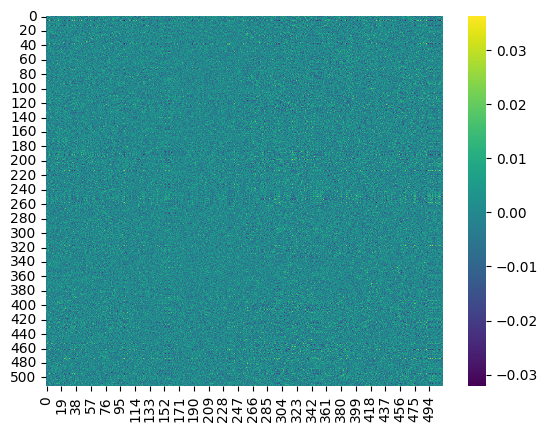

Attention Layer: transformer_encoder.layers.1.self_attn


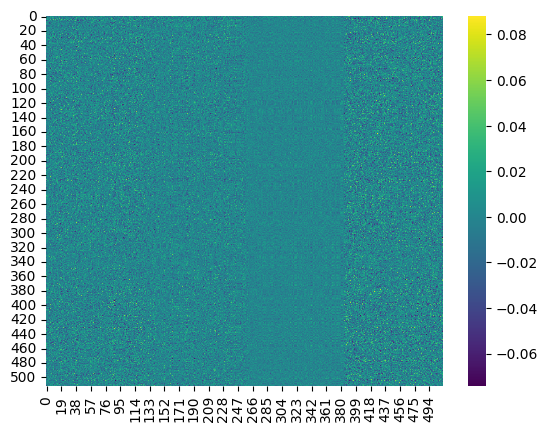

Attention Layer: transformer_encoder.layers.2.self_attn


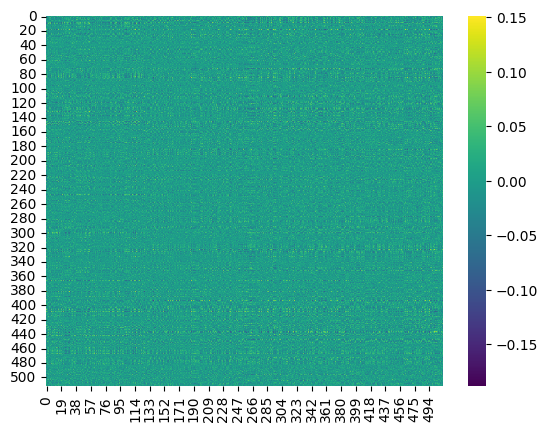

Attention Layer: transformer_encoder.layers.3.self_attn


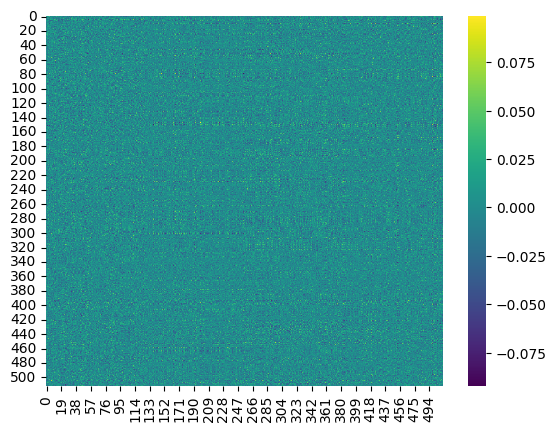

Attention Layer: transformer_encoder.layers.4.self_attn


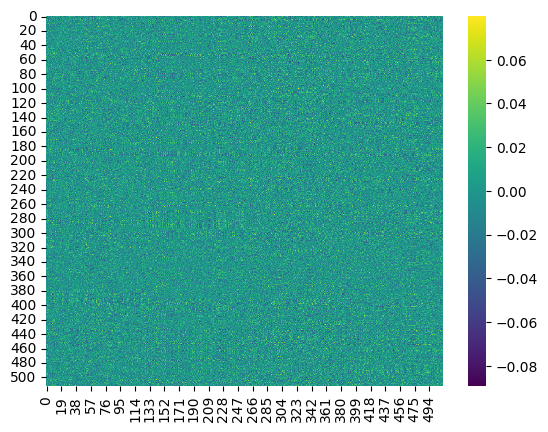

Attention Layer: transformer_encoder.layers.5.self_attn


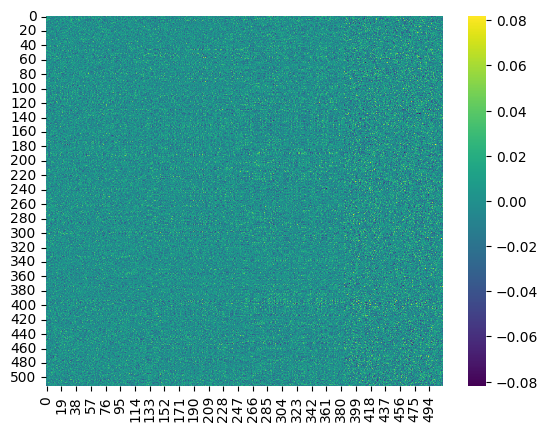

Attention Layer: transformer_encoder.layers.6.self_attn


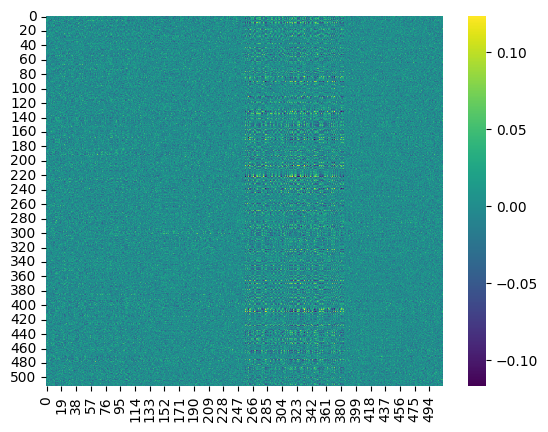

Attention Layer: transformer_encoder.layers.7.self_attn


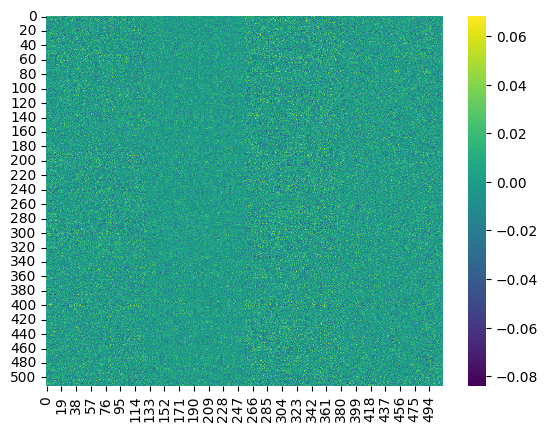

Attention Layer: transformer_encoder.layers.8.self_attn


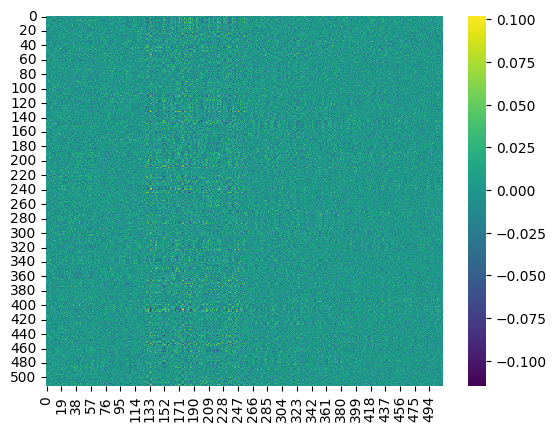

Attention Layer: transformer_encoder.layers.9.self_attn


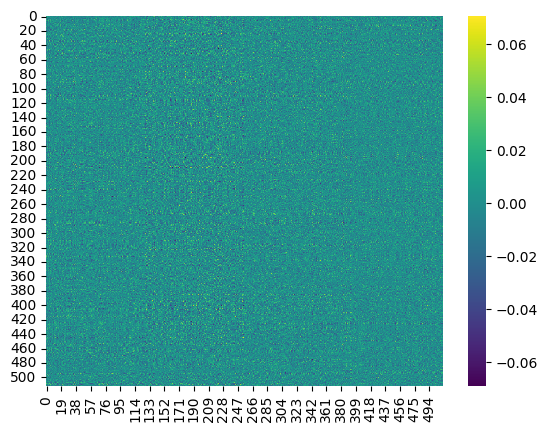

Attention Layer: transformer_encoder.layers.10.self_attn


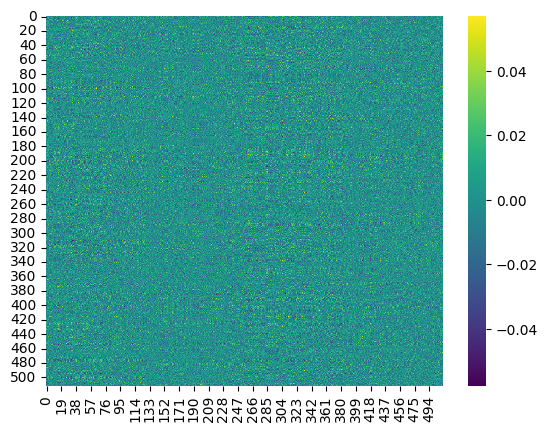

Attention Layer: transformer_encoder.layers.11.self_attn


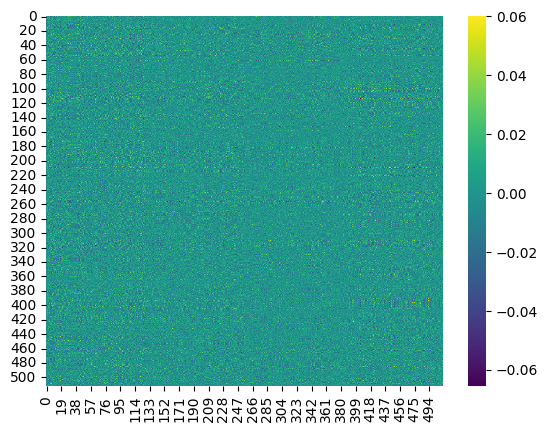

In [13]:
# --------------------- plotting attention weights Start --------------------- 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
def freeze_model_parameters(model):
    for param in model.parameters():
        param.requires_grad = False
        
def plot_tensor_heatmap(tensor):
    matrix = tensor.detach().numpy()
    sns.heatmap(matrix, cmap="viridis")
    plt.show()
    
def plot_attention_weights(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.MultiheadAttention):
            print(f"Attention Layer: {name}")
            # print(module.out_proj.weight.shape)
            plot_tensor_heatmap(module.out_proj.weight)
ds = test_datasets[evaluation_dataset_index]
xs, ys = ds[1].clone(), ds[2].clone()
eval_position = xs.shape[0] // 2
train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
test_xs, test_ys = xs[eval_position:], ys[eval_position:]

classifier = TabPFNClassifier(device='cpu')
freeze_model_parameters(classifier.model[2])
classifier.fit(train_xs, train_ys)

prediction_ = classifier.predict_proba(test_xs)
            
plot_attention_weights(classifier.model[2])

# --------------------- plotting attention weights End ---------------------

### Run on all datasets
This section runs a differentiable hyperparameter tuning run and saves the results to a results file, which can be inserted in TabularEval.ipynb to compare to other baselines.

In [ ]:
eval_positions=[1000]
bptt=2000

N_models = 3
models_per_block = 1

eval_addition = 'user_run'
device = 'cpu'

eval_model_range(i_range=[0], e=-1
                          , valid_datasets=[]#cc_valid_datasets_multiclass
                          , test_datasets=cc_test_datasets_multiclass
                          , train_datasets=[]
                          , eval_positions_test=eval_positions
                          , bptt_test=bptt
                          , add_name=model_string
                          , base_path=base_path
                          , selection_metric='auc'
                          , best_grad_steps=0
                          , eval_addition=eval_addition
                          , N_ensemble_configurations_list = [32]
                          , device=device)#range(0, 10)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Running eval dataset with final params (no gradients)..
Running with 32 ensemble_configurations


In [ ]:
# --------------------- permutate along embed dim Start --------------------- 
def permutate_embed_dim(input_tensor):
    batch_size, sequence_dim, embed_dim = input_tensor.size()

    # Generate random permutation
    perm = torch.randperm(embed_dim)

    # Expand permutation tensor
    perm = perm.unsqueeze(0).unsqueeze(1).expand(batch_size, sequence_dim, embed_dim)

    # Apply permutation to input tensor
    input_tensor_permuted = input_tensor.gather(2, perm)

    return input_tensor_permuted
# --------------------- permutate along embed dim End --------------------- 

# --------------------- check permutation Start --------------------- 
test = torch.tensor([[[1,2,3,4,5,6]],[[3,4,5,6,7,8]]])
test.shape
print(permutate_embed_dim(test))
# --------------------- check permutation End --------------------- 




In [ ]:

# --------------------- split x_train and y_train Bagging Start --------------------- 
import random

def sample_k_train_test_bags(x_train, y_train, k = 10): 
    results = [] 
    b, s, e = x_train.size() # not sure if this is the correct order
    indices = list(range(s)) 
    for i in range(k):
        random.shuffle(indices)  # Shuffle the indices randomly
        selected_indices = indices[:random.randint(1, s)]  # Select a random subset of indices

        # Use the selected indices to sample from the input tensor
        sampled_x_train = x_train[:, selected_indices, :]
        sampled_y_train = y_train[:, selected_indices]
        
        # Pad the sampled tensors back to the original size
        padded_x_train = torch.zeros((b, s, e), dtype=x_train.dtype)
        padded_y_train = torch.zeros((b, s), dtype=y_train.dtype)

        padded_x_train[:, selected_indices, :] = sampled_x_train
        padded_y_train[:, selected_indices] = sampled_y_train

        results.append((padded_x_train, padded_y_train))
    return results
 
# --------------------- split x_train and y_train Bagging End --------------------- 

# --------------------- check split x_train and y_train Start --------------------- 
x_train = torch.tensor([[[1,2,3,4,5],[4,5,6,7,8],[6,7,8,9,10]]])
y_train = torch.tensor([[1,2,4]])
print(f"x_train {x_train.shape}")
print(f"y_train {y_train.shape}")
results = sample_k_train_test_bags(x_train=x_train, y_train=y_train, k= 10)
print(results)
# --------------------- check split x_train and y_train End --------------------- 

In [ ]:
# --------------------- split x_train and y_train Pasting Start --------------------- 
def sample_k_train_test_pasts(x_train, y_train, k = 10): 
    results = [] 
    k = min(x_train.shape[-1], k) # if k is larger then sequence length -> clip it
    b, s, e = x_train.size() # not sure if this is the correct order
    indices = list(range(s)) 
    
    subset_indices = []  # List to store subset indices

    for _ in range(k):
        subset = random.sample(indices, len(indices))  # Sampling without replacement
        subset_indices.append(subset)

        for index in subset:
            indices.remove(index)  # Remove the sampled indices from the original list
        
        if len(indices) < 1: break
    
    for sampled_indices in subset_indices:

        # Use the selected indices to sample from the input tensor
        sampled_x_train = x_train[:, sampled_indices, :]
        sampled_y_train = y_train[:, sampled_indices]
        
        # Pad the sampled tensors back to the original size
        padded_x_train = torch.zeros((b, s, e), dtype=x_train.dtype)
        padded_y_train = torch.zeros((b, s), dtype=y_train.dtype)

        padded_x_train[:, sampled_x_train, :] = sampled_x_train
        padded_y_train[:, sampled_x_train] = sampled_y_train

        results.append((padded_x_train, padded_y_train))
    return results
# --------------------- split x_train and y_train Pasting End --------------------- 


### Run generalization experiments

In [ ]:
# Loading longer OpenML Datasets for generalization experiments (optional)
test_datasets_multiclass, test_datasets_multiclass_df = load_openml_list(test_dids_classification, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


In [ ]:
test_datasets_longer_generalization = [ds for ds in test_datasets_multiclass if ds[1].shape[0] >= 10000]

In [ ]:
def test_gen(classifier_key, split):
    ces = []
    for k in tqdm(range(0, len(test_datasets_longer_generalization))):
        x, y = test_datasets_longer_generalization[k][1], test_datasets_longer_generalization[k][2].numpy()
        x = normalize_data(x).numpy()
        x[np.isnan(x)] = 0.0
        print(x.shape[0])
        
        if x.shape[0] < 10000:
            continue
        if len(np.unique(y)) > 2:
            continue

        for bptt_ in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]:
            bptt_ = bptt_ // 2
            #model = classifier_dict[classifier_key]
            x_, y_ = x.copy(), y.copy()
            x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.5, random_state=split)
            x_train, y_train = x_train[0:bptt_], y_train[0:bptt_]
            model.fit(x_train, y_train) # ranking[0:j]
            pred = model.predict_proba(x_test) # ranking[0:j]
            ce = tabular_metrics.auc_metric(y_test, pred)
            ces += [{'bptt': bptt_, 'k': k, 'm': float(ce), 'method': classifier_key, 'split': split}]
            print(x_train.shape, ce)
    with open(f'generalization_{classifier_key}_{split}.obj',"wb") as fh:
        pickle.dump(ces,fh)

In [ ]:
test_gen('tabpfn', 0)

In [ ]:
ces = []
for classifier_key in classifier_dict:
    for split in range(0,5):
        try:
            with open(f'generalization_{classifier_key}_{split}.obj',"rb") as fh:
                ces += pickle.load(fh)
        except:
            pass
df = pd.DataFrame(ces)

In [ ]:
df = df.groupby(['bptt', 'split', 'method']).mean().reset_index()
fig, ax = plt.subplots(1,1, figsize=(8, 6)) # , sharey=True

colors = iter(sns.color_palette("tab10"))
for classifier_key in ['tabpfn']:#df.method.unique():
    c = next(colors)
    sns.lineplot(x='bptt', y='m', data=df[df.method==classifier_key], label=relabeler[classifier_key], color=c, ax = ax)
    #ax.text(x = df[df.method==classifier_key].iloc[50].bptt, # x-coordinate position of data label
    # y = df[df.method==classifier_key].iloc[50].m, # y-coordinate position of data label, adjusted to be 150 below the data point
    # s = classifier_key, # data label, formatted to ignore decimals
    # color = c, size=12) # set colour of line
    
ax.get_legend().remove()
ax.set(xlabel='Number of training samples')
ax.set(ylabel='ROC AUC')
plt.axvline(x=1024, linestyle='dashed', color='red')
plt.ylim((0.73,0.79))
plt.xlim((250,5000))